# Constraining FATES parameters for conifer allometry

This notebook uses observational data from the BAAD database to constrain fates parameters for a oak and conifer allometry

## Setup <a class="anchor" id="setup"></a>
* Import libraries
* Set paths to data
* Define constants

In [70]:
#import libraries
import pandas as pd
import numpy as np
from numpy import genfromtxt
import math
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
import os
#jupyter settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.min_rows', 200)
import re

In [71]:
path_to_trait_obs = "/home/adam/cloud/gdrive/postdoc/parameters/param_data/trait_observations"
baad_data = os.path.join(path_to_trait_obs,"conifer_allometry/baad_data/baad_data.csv")
urban_tree_db = os.path.join(path_to_trait_obs,'conifer_allometry/McPherson_urban_tree_database/TS3_Raw_tree_data.csv')
tallo_db = os.path.join(path_to_trait_obs,"conifer_allometry/Tallo.csv")

pollys_allom_params = os.path.join("/home/adam/cloud/gdrive/postdoc/parameters/pollys_allom_params.csv")

write_to_csv = False
pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen']

## Constants

In [72]:
#define constants
m2_per_cm2 = 1e-4
g_biomass_per_g_C = 2
m2_per_mm2 = 1e-6
mg_per_g = 1e3
g_per_kg = 1000
mm2_per_cm2 = 100

### Define target trees

In [73]:
target_trees = ['Pinus ponderosa','Calocedrus decurrens','Abies concolor','Quercus chrysolepis'
                'Quercus kelloggii','Quercus douglasii','Abies magnifica']

### Define allom df

In [74]:
allom_vars = ['species','dbh_cm','height_m','leaf_biomass_kgC',
              'agwb_kgC','agb_kgC','crown_area_m2','source']

## Explore and import data from Baad database

Baad only has data for ponderosa pine

In [75]:
# This just includes the species we're primarily trying to model.
# The target species are used for allometry
## Import crown area data for PIPO from Baad
baad_df = pd.read_csv(baad_data)

for sp in target_trees:
    print(len(baad_df[baad_df['species'] == sp]))

272
0
0
0
0
0


### Clean Baad data

In [76]:
## Import data for PIPO from Baad
baad_df = pd.read_csv(baad_data)
baad_df = baad_df.loc[baad_df['species'] == "Pinus ponderosa"]
baad_df = baad_df[['species','d.bh','m.lf','a.cp','h.t']]
baad_df['crown_area_m2'] = baad_df['a.cp']
baad_df['leaf_biomass_kgC'] = baad_df['m.lf'] / g_biomass_per_g_C
baad_df['dbh_cm'] = baad_df['d.bh'] * 100
baad_df['height_m'] = baad_df['h.t']
baad_df['agwb_kgC'] = None
baad_df['agb_kgC'] = None
baad_df['source'] = "Baad"
baad_df = baad_df[allom_vars]
#baad_df = baad_df[]
print(baad_df.info())
baad_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 3428 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           272 non-null    object 
 1   dbh_cm            263 non-null    float64
 2   height_m          272 non-null    float64
 3   leaf_biomass_kgC  154 non-null    float64
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     125 non-null    float64
 7   source            272 non-null    object 
dtypes: float64(4), object(4)
memory usage: 19.1+ KB
None


,species,dbh_cm,height_m,leaf_biomass_kgC,agwb_kgC,agb_kgC,crown_area_m2,source
3428,Pinus ponderosa,NaN,0.70104,0.042003,None,None,0.186793,Baad
3455,Pinus ponderosa,NaN,1.18872,0.022000,None,None,0.236409,Baad
3464,Pinus ponderosa,NaN,1.31064,0.123493,None,None,0.794598,Baad
3470,Pinus ponderosa,NaN,1.37160,0.120499,None,None,0.456037,Baad
3477,Pinus ponderosa,0.762,1.40208,0.033498,None,None,0.263407,Baad


## Explore and import data from McPerhson urban tree database

In [77]:
mcpherson_df = pd.read_csv(urban_tree_db)
mcpherson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14487 entries, 0 to 14486
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DbaseID         14487 non-null  int64  
 1   Region          14487 non-null  object 
 2   City            14487 non-null  object 
 3   Source          14487 non-null  object 
 4   TreeID          14487 non-null  object 
 5   Zone            14487 non-null  object 
 6   Park/Street     14487 non-null  object 
 7   SpCode          14487 non-null  object 
 8   ScientificName  14487 non-null  object 
 9   CommonName      14487 non-null  object 
 10  TreeType        14487 non-null  object 
 11  address         14487 non-null  object 
 12  street          14487 non-null  object 
 13  side            14487 non-null  object 
 14  cell            14487 non-null  int64  
 15  OnStreet        14487 non-null  object 
 16  FromStreet      14487 non-null  object 
 17  ToStreet        14487 non-null 

### Clean McPherson data

In [78]:
mcpherson_df = pd.read_csv(urban_tree_db)

# McPherson tree codes of interest
mcpher_codes = ['PIPO','PSME','QUAG','CADE2']

# McPherson vars of interest
mcpher_vars = ['SpCode','ScientificName','DBH (cm)','Age','TreeHt (m)','AvgCdia (m)','Leaf (m2)']

mcpherson_df = mcpherson_df.loc[mcpherson_df['SpCode'].isin(mcpher_codes)][mcpher_vars]
mcpherson_df.head()

#Clean
mcpherson_df['species'] = mcpherson_df['ScientificName']
mcpherson_df['dbh_cm'] = mcpherson_df['DBH (cm)']
mcpherson_df['height_m'] = mcpherson_df['TreeHt (m)']
mcpherson_df['leaf_biomass_kgC'] = None
mcpherson_df['agwb_kgC'] = None
mcpherson_df['agb_kgC'] = None
mcpherson_df['crown_area_m2'] = math.pi * (mcpherson_df['AvgCdia (m)'] / 2)**2
mcpherson_df['source'] = "McPherson_2016"
mcpherson_df = mcpherson_df[allom_vars]
print(mcpherson_df.info())

# Could do this if helpful
#Add foliar biomass for QUAG to McPherson data
#mcpherson_df['leaf_biomass_g'] = mcpherson_df['Leaf (m2)'] * 251.98 # QUAG foliar biomass factor taken from Table 6 of McPherson et al., 2016

<class 'pandas.core.frame.DataFrame'>
Index: 241 entries, 1343 to 13462
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           241 non-null    object 
 1   dbh_cm            241 non-null    float64
 2   height_m          241 non-null    float64
 3   leaf_biomass_kgC  0 non-null      object 
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     241 non-null    float64
 7   source            241 non-null    object 
dtypes: float64(3), object(5)
memory usage: 16.9+ KB
None


## Explore and import data from Tallo

In [79]:
tallo_df = pd.read_csv(tallo_db)
tallo_df = tallo_df.loc[tallo_df['species'].isin(target_trees)]
print(tallo_df.species.value_counts())
print(tallo_df.info())

species
Pinus ponderosa         623
Abies magnifica         210
Abies concolor          195
Quercus douglasii        51
Calocedrus decurrens     14
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 80266 to 495591
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tree_id               1093 non-null   object 
 1   division              1093 non-null   object 
 2   family                1093 non-null   object 
 3   genus                 1093 non-null   object 
 4   species               1093 non-null   object 
 5   latitude              1093 non-null   float64
 6   longitude             1093 non-null   float64
 7   stem_diameter_cm      1093 non-null   float64
 8   height_m              1093 non-null   float64
 9   crown_radius_m        527 non-null    float64
 10  height_outlier        1093 non-null   object 
 11  crown_radius_outlier  1093 non-null   object 
 12 

### Clean tallo data

In [80]:
tallo_df = pd.read_csv(tallo_db)

tallo_df = tallo_df.loc[tallo_df['species'].isin(target_trees)]

#Clean
tallo_df['dbh_cm'] = tallo_df['stem_diameter_cm']
tallo_df['leaf_biomass_kgC'] = None
tallo_df['agwb_kgC'] = None
tallo_df['agb_kgC'] = None
tallo_df['crown_area_m2'] = math.pi * tallo_df['crown_radius_m']**2
tallo_df['source'] = "Tallo"
tallo_df = tallo_df[allom_vars]
print(tallo_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 80266 to 495591
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1093 non-null   object 
 1   dbh_cm            1093 non-null   float64
 2   height_m          1093 non-null   float64
 3   leaf_biomass_kgC  0 non-null      object 
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     527 non-null    float64
 7   source            1093 non-null   object 
dtypes: float64(3), object(5)
memory usage: 76.9+ KB
None


In [81]:
tallo_df.head()

,species,dbh_cm,height_m,leaf_biomass_kgC,agwb_kgC,agb_kgC,crown_area_m2,source
80266,Pinus ponderosa,1.0,1.6,None,None,None,0.636173,Tallo
80455,Pinus ponderosa,1.3,2.0,None,None,None,NaN,Tallo
80585,Pinus ponderosa,1.5,2.6,None,None,None,NaN,Tallo
80586,Pinus ponderosa,1.5,1.8,None,None,None,NaN,Tallo
80589,Pinus ponderosa,1.5,1.7,None,None,None,1.130973,Tallo


## Join conifer allometry data

In [82]:
conifer_allometry_df = pd.concat([tallo_df,mcpherson_df,baad_df])
conifer_allometry_df.info()

#Pick up here with adding total above-ground biomass to the dataframe using the equations on Chojnacky

# General plan forward is to give cedar the same allometry as pine, and then tweak fir to have slightly
# more leaf biomass per unit of dbh (same ratio that polly used?)

# Then consider giving fir a different crown area function too
# See if cedar needs to have a different crown area function from pine too?

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, 80266 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           1606 non-null   object 
 1   dbh_cm            1597 non-null   float64
 2   height_m          1606 non-null   float64
 3   leaf_biomass_kgC  154 non-null    float64
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     893 non-null    float64
 7   source            1606 non-null   object 
dtypes: float64(4), object(4)
memory usage: 112.9+ KB


## Functions

In [83]:
#diamter to height
def d2h_obrien(ds,p1,p2,dbh_maxh):
    '''Input; dbh (cm)
    Returns: height (m)'''
    
    h = []
    for d in ds:
        h.append(10.0**(math.log10(min(d,dbh_maxh))*p1+p2))
    return(h)

# diameter to max leaf biomass
# why no carbon to leaf biomass multiplier here (not in the main fates code?)
# https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L1403
def d2blmax_salda(ds,p1,p2,p3,wood_density,dbh_maxh):
    '''Input; dbh (cm)
    Returns: plant leaf biomass (kg)'''
    
    blmax = []
    
    for d in ds:
        if d < dbh_maxh:
            blmax.append(p1 * d**p2 * wood_density**p3)
        else:
            blmax.append(p1 * dbh_maxh**p2 * wood_density**p3)
    
    return(blmax)

#diameter and height to above-ground biomass (just structural and sapwood biomass)
def dh2bagw_salda(p1, p2, p3, p4, allom_agb_frac,ds,heights,wood_density):
    
    '''Input; dbh (cm)
    Returns: woody above-ground biomass (kg)'''
    
    bagw = []
    
    for d,h in zip(ds,heights):
    
        bagw.append(allom_agb_frac*p1*(h**p2)*(d**p3)*(wood_density**p4))
    
    return(bagw)

#2-param power function for diameter (cm) to plant above-ground biomass (kgC)
def d2bagw_2pwr(d,p1,p2,c2b):
    bagw = []
    for i in d:
        bagw.append((p1 * i**p2)/c2b)
    return bagw

#This is a power function for leaf biomass from plant diameter
def d2blmax_2pwr(d,p1,p2,c2b,dbh_maxh):
    '''input dbh [cm]
    output: plant leaf biomass [kg C]'''
    blmax = []
    for i in d:
        blmax.append((p1*min(i,dbh_maxh)**p2) / c2b)   
    return blmax

def carea_2pwr(ds, p1, p2):
    c = []
    for d in ds:
        c.append(p1 * d ** p2)
    return c

def d_to_crown_area_fates(ds,d2bl_p2,d2bl_ediff,spread,d2ca_max,d2ca_min, dbh_maxh):
    
    '''Input dbh (cm)
    Output: crown area (m2)'''
    
    ca = []
    cd = []
    
    for d in ds:
        #from fates
        
        if d > dbh_maxh:
            d = dbh_maxh
        
        crown_area_to_dbh_exponent = d2bl_p2 + d2bl_ediff
        spreadterm = spread * d2ca_max + (1.0 - spread) * d2ca_min
        tmp_ca = spreadterm * d ** crown_area_to_dbh_exponent
        ca.append(tmp_ca)

        #convert to crown diameter
        cd.append(2 * math.sqrt(tmp_ca/math.pi))

    return ca,cd

def age_senescence(age, mort_r_age_senescence, mort_ip_age_senescence):
    out = []
    for i in age:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_age_senescence * (i - mort_ip_age_senescence))))
    return out


def size_senescence(size, mort_r_size_senescence, mort_ip_size_senescence):
    out = []
    for i in size:
        out.append(1.0 / (1.0 + math.exp(-1 * mort_r_size_senescence * (i - mort_ip_size_senescence))))
    return out

def prep_data_for_curve_fit(df,sp,dbh_var,var):
    df = df.loc[df['species'] == sp]
    
    if type(var) == list:
        var.append(dbh_var) 
        df = df[var].dropna()
    else:
        df = df[[dbh_var,var]].dropna()
    return df


    
def add_param_to_allometry_dict(fates_name,min_max_mean):
    
    allometry_dict["fates_name"].append(fates_name)
    allometry_dict["min_value"].append(min_max_mean[0])
    allometry_dict["max_value"].append(min_max_mean[1])
    allometry_dict["mean"].append(min_max_mean[2])
    
    
# This function gets the optimal parameter value from the curve fit function and
# also returns the min and max values for the parameter (+- 1 SD of error)
def getMeanMinMaxofParam(param):
    sd_of_param = np.sqrt(np.diag(pcov))[param]
    mean_value = popt[param]
    min_value = popt[param] - sd_of_param
    max_value = popt[param] + sd_of_param
    return(np.array([min_value, max_value, mean_value]))

def convert_to_fates_units(trait_name,input_units,input_value):

    
    if ("SLA" in trait_name) | ("Specific leaf area" in trait_name) and input_units == "mm2 mg-1":  
        output_value = input_value * m2_per_mm2 * mg_per_g * g_biomass_per_g_C
        return output_value

    elif "Leaf nitrogen" in trait_name and input_units == "mg/g":
        output_value = input_value * g_per_mg * g_biomass_per_g_C
        return output_value

    elif "Stem specific density" in trait_name and input_units == "g/cm3":
        output_value = input_value
        return output_value
    
    # Anaker conversions
    elif trait_name == "log(SLA cm2 g-1)":
        output_value = np.exp(input_value) * m2_per_cm2 * g_biomass_per_g_C
        return output_value
        
    elif trait_name == 'log(wood density g ml-1)':
        output_value = np.exp(input_value)
        return output_value
        
    elif trait_name == 'log(N %)':
        output_value = np.exp(input_value) * 1e-2 * g_biomass_per_g_C
        return output_value
    
    #Jepson leaf N
    elif trait_name == "Leaf Nmass":
    
        # muliplying by 1e-2 is to reverse the "per cent"  
        output_value = input_value * 1e-2 * g_biomass_per_g_C
        return output_value
    
    elif "Wood density" in trait_name:
        output_value = input_value
        return output_value
    
    elif trait_name == "Leaf area to sapwood area" and input_units == "mm2 mm-2":
        output_value = input_value * 1e-4
        return output_value
    
    elif "Vcmax" in trait_name and input_units == "micro mol m-2 s-1":
        output_value = input_value
        return output_value
    
    else:
        #print("No unit conversion known for:", trait_name)
        return None
    
def convert_to_fates_param_name(input_trait_name):
    if ("SLA" in input_trait_name) | ('Specific leaf area' in input_trait_name):
        return "fates_leaf_slatop"
    
    elif ("wood density" in input_trait_name) |  ("Wood density" in input_trait_name):
        return "fates_wood_density"
    
    elif ("N %" in input_trait_name) | ("Leaf Nmass" in input_trait_name):
        return "fates_stoich_nitr"
    
    elif "Leaf nitrogen (N) content per leaf dry mass" in input_trait_name:
        return "fates_stoich_nitr"
    
    elif "Leaf area to sapwood area" in input_trait_name:
        return "fates_allom_la_per_sa_int"
    
    elif "Vcmax" in input_trait_name:
        return "fates_leaf_vcmax25top"
    
    else:
        return None
    
def get_sources(df,variable):
    return df.loc[df.fates_name == variable].source.unique()

def get_range_data(df,subset_name):

    summary_stats = df.groupby('fates_name')['fates_value'].agg(
        min_value='min',
        max_value='max',
        mean='mean',
        median='median',
        sample_size='size'
    )

    summary_stats['subset_name'] = subset_name
    
    return summary_stats

#def check_vai_max(dbh,sai_scaler,sla,d2bl1):
    

## Import Polly's parameters

In [84]:
#Import polly's parameters
polly_allom = pd.read_csv(pollys_allom_params)

#Put them in a dictionary for easier access
pollys_params = [{},{},{}]
for pft in range(0,3):
    for index, row in polly_allom.iterrows():
        pollys_params[pft][row['param']] = row[pft+1]

## Set up dictionary to store allometry param values

In [85]:
allometry_dict = {}

for i in ['fates_name','min_value','max_value','mean']:
    allometry_dict[i] = []
    
# diameters [cm] to plot allom functions against
diams = list(range(1,100))

## Diameter to height

In [86]:
baad_pipo_height = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","height_m")
baad_pipo_height.info()
# dbh = utdb.loc[utdb['SpCode'] == "CADE2"]["DBH (cm)"]
# h = utdb.loc[utdb['SpCode'] == "CADE2"]['TreeHt (m)']
# plt.scatter(dbh,h)

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 3477 to 12276
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dbh_cm    263 non-null    float64
 1   height_m  263 non-null    float64
dtypes: float64(2)
memory usage: 6.2 KB


### Find optimal params

In [87]:
#For PIPO
popt, pcov = curve_fit(lambda d, p1, p2: d2h_obrien(d, p1, p2, dbh_maxh=80),
                       xdata=list(baad_pipo_height['dbh_cm']), ydata=list(baad_pipo_height['height_m']))

fates_allom_d2h1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2h1",fates_allom_d2h1)
fates_allom_d2h2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2h2",fates_allom_d2h2)

# Add param
# Think about how to set this up for multi-pft
add_param_to_allometry_dict("fates_allom_d2h1",fates_allom_d2h1)
add_param_to_allometry_dict("fates_allom_d2h2",fates_allom_d2h2)


#Other pfts

fates_allom_d2h1 [0.80899151 0.85371989 0.8313557 ]
fates_allom_d2h2 [-0.02815632  0.04455624  0.00819996]


### Visualize d2h params

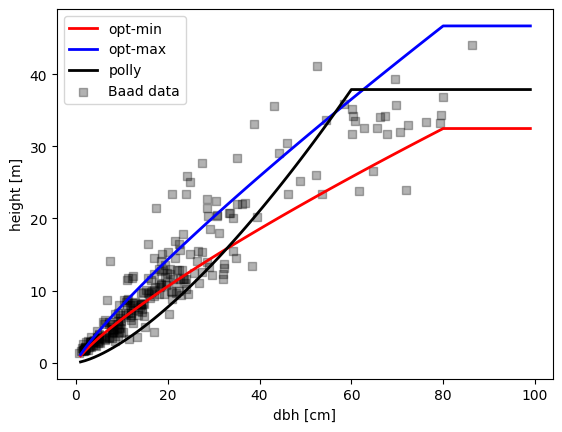

In [88]:
#optimal min
h_opt = d2h_obrien(ds = diams,
                            p1 = fates_allom_d2h1[0],
                            p2 = fates_allom_d2h2[0],
                            dbh_maxh = 80)

plt.plot(diams, h_opt, label = "opt-min",color = "red", lw = 2)

#optimal max
h_opt = d2h_obrien(ds = diams,
                            p1 = fates_allom_d2h1[1],
                            p2 = fates_allom_d2h2[1],
                            dbh_maxh = 80)

plt.plot(diams, h_opt, label = "opt-max",color = "blue", lw = 2)


#Polly's
h_polly = d2h_obrien(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2h1"],
                            p2 = pollys_params[0]["fates_allom_d2h2"],
                            dbh_maxh = 60)
plt.plot(diams, h_polly, label = "polly",color = "black", lw = 2)

#Baad data
plt.scatter(baad_pipo_height.dbh_cm, baad_pipo_height['height_m'], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('height [m]')
plt.legend()
plt.show()

## Diameter to leaf biomass

Underestimates leaf biomass of large trees

In [89]:
baad_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 3428 to 12276
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   species           272 non-null    object 
 1   dbh_cm            263 non-null    float64
 2   height_m          272 non-null    float64
 3   leaf_biomass_kgC  154 non-null    float64
 4   agwb_kgC          0 non-null      object 
 5   agb_kgC           0 non-null      object 
 6   crown_area_m2     125 non-null    float64
 7   source            272 non-null    object 
dtypes: float64(4), object(4)
memory usage: 19.1+ KB


In [90]:
baad_pipo_leafbio = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","leaf_biomass_kgC")

### Find optimal params

In [91]:
popt, pcov = curve_fit(lambda d, p1, p2, p3: d2blmax_salda(d, p1, p2, p3, wood_density= 0.446, dbh_maxh=60),
                       xdata=list(baad_pipo_leafbio['dbh_cm']), ydata=list(baad_pipo_leafbio["leaf_biomass_kgC"]))


# Issue grabbing the se of the parameters here
fates_allom_d2bl1 = getMeanMinMaxofParam(param = 0)
print("fates_allom_d2bl1",fates_allom_d2bl1)

fates_allom_d2bl2 = getMeanMinMaxofParam(param = 1)
print("fates_allom_d2bl2",fates_allom_d2bl2)

fates_allom_d2bl3 = getMeanMinMaxofParam(param = 2)
print("fates_allom_d2bl3",fates_allom_d2bl3)

add_param_to_allometry_dict("fates_allom_d2bl1",fates_allom_d2bl1)
add_param_to_allometry_dict("fates_allom_d2bl2",fates_allom_d2bl2)
add_param_to_allometry_dict("fates_allom_d2bl3",fates_allom_d2bl3)

fates_allom_d2bl1 [-6.33725277e+05  6.33725469e+05  9.63471087e-02]
fates_allom_d2bl2 [1.94904159 2.49297415 2.22100787]
fates_allom_d2bl3 [-8.14617972e+06  8.14618683e+06  3.55591634e+00]


In [92]:
print("Pollys d2bl2",pollys_params[0]["fates_allom_d2bl2"])

Pollys d2bl2 1.5


### Visualize leaf biomass allometry

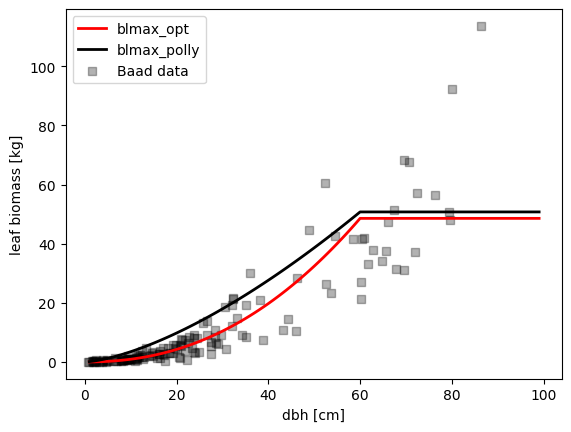

In [93]:
#Opt
blmax_opt = d2blmax_salda(ds = diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            p3 = fates_allom_d2bl3[2],
                            wood_density = 0.446,
                            dbh_maxh = 60)
plt.plot(diams, blmax_opt, label = "blmax_opt",color = "red", lw = 2)


#Polly
blmax_polly = d2blmax_salda(ds = diams,
                            p1 = pollys_params[0]["fates_allom_d2bl1"],
                            p2 = pollys_params[0]["fates_allom_d2bl2"],
                            p3 = pollys_params[0]["fates_allom_d2bl3"],
                            wood_density = 0.446,
                            dbh_maxh = 60)
plt.plot(diams, blmax_polly, label = "blmax_polly",color = "black", lw = 2)



#Baad data
plt.scatter(baad_pipo_leafbio.dbh_cm, baad_pipo_leafbio["leaf_biomass_kgC"], label = "Baad data",color = "black", marker = "s", alpha = 0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('leaf biomass [kg]')
plt.legend()
plt.show()

## Diameter to crown area

### Find optimal params

In [101]:
allow_spread = False

baad_pipo_ca = prep_data_for_curve_fit(baad_df,"Pinus ponderosa","dbh_cm","crown_area_m2")

popt, pcov = curve_fit(lambda d, p1, p2: carea_2pwr(d, p1, p2),
                       xdata=list(baad_pipo_ca['dbh_cm']), ydata=list(baad_pipo_ca["crown_area_m2"]))

# p1 is the base of the 2 parameter power function.
# In the FATES code it is called the 'spread term'
# The spread term is actually a dynamic variable based on the
# site-level stand density and two parameters (fates_allom_d2ca_coefficient_max and
# fates_allom_d2ca_coefficient_in) that determine the amount
# of elasticity the crowns should have to respond to the stand density.
# Caution: fates_allom_d2ca_coefficient_(min/max) both affect the ultimate
# crown area

d2ca_base = getMeanMinMaxofParam(param = 0)
d2ca_expo = getMeanMinMaxofParam(param = 1)

print("d2ca_base (derived from curve fit):", d2ca_base)
print("d2ca_expo (derived from curve fit):",d2ca_expo)

if allow_spread == True:
    # Use variation in the estimate of the base parameter for fates_allom_d2ca_coefficient_(min/max)
    fates_allom_d2ca_coefficient_min = [d2ca_base[0] * 0.85, d2ca_base[0] * 1.15, d2ca_base[0]]
    fates_allom_d2ca_coefficient_max = [d2ca_base[1] * 0.85, d2ca_base[1] * 1.15, d2ca_base[1]]

else:
    fates_allom_d2ca_coefficient_min = fates_allom_d2ca_coefficient_max = d2ca_base

print("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
print("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)


# The exponent in FATES is calculated by adding and "exponent diff param" to fates_allom_d2bl2

print("fates_allom_d2bl2",fates_allom_d2bl2)
fates_allom_blca_expnt_diff = d2ca_expo - fates_allom_d2bl2
print("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)


add_param_to_allometry_dict("fates_allom_d2ca_coefficient_min",fates_allom_d2ca_coefficient_min)
add_param_to_allometry_dict("fates_allom_d2ca_coefficient_max",fates_allom_d2ca_coefficient_max)
add_param_to_allometry_dict("fates_allom_blca_expnt_diff",fates_allom_blca_expnt_diff)

d2ca_base (derived from curve fit): [0.02887947 0.0828723  0.05587589]
d2ca_expo (derived from curve fit): [1.49537907 1.73069078 1.61303492]
fates_allom_d2ca_coefficient_min [0.02887947 0.0828723  0.05587589]
fates_allom_d2ca_coefficient_max [0.02887947 0.0828723  0.05587589]
fates_allom_d2bl2 [1.94904159 2.49297415 2.22100787]
fates_allom_blca_expnt_diff [-0.45366252 -0.76228337 -0.60797295]


[Gill et al., 2000 model](https://www.sciencedirect.com/science/article/pii/S0378112799001139?via%3Dihub#aep-section-id11)



In [95]:
def Gill_2000(ds,b0,b1):
    
    r = []
    ca = []
    
    for d in ds:
        radius_tmp = b0 + b1 * d
        r.append(radius_tmp)
        ca_tmp = math.pi * radius_tmp **2
        ca.append(ca_tmp)
    return r,ca

### Visualize diameter to crown area

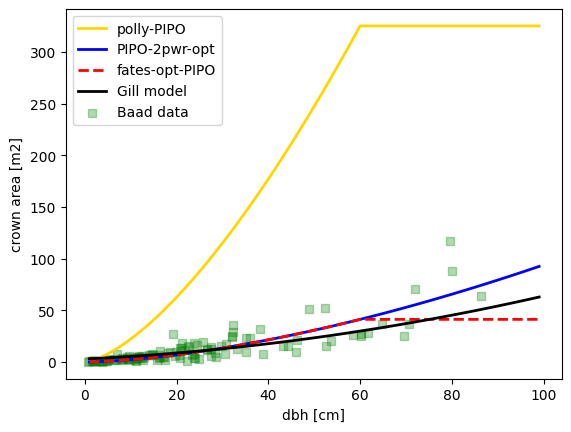

In [96]:
#Polly's params
ca,cd = d_to_crown_area_fates(ds=diams,
                                         d2bl_p2=pollys_params[0]['fates_allom_d2bl2'],
                                         d2bl_ediff=pollys_params[0]["fates_allom_blca_expnt_diff"],
                                         d2ca_max=pollys_params[0]["fates_allom_d2ca_coefficient_max"],
                                         d2ca_min=pollys_params[0]["fates_allom_d2ca_coefficient_min"],
                                         spread=0.5,dbh_maxh=60)
plt.plot(diams, ca, label = "polly-PIPO",color = pft_colors[0], lw = 2)

#Optimized 2 param pwr function
# Simple crown area model with fitted base and exponent 
crown_area_model = carea_2pwr(diams, d2ca_base[2], d2ca_expo[2])
plt.plot(diams, crown_area_model,label = "PIPO-2pwr-opt",color = "blue", lw = 2)

# Optimized fates params
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=fates_allom_d2bl2[2],
                              d2bl_ediff=fates_allom_blca_expnt_diff[2],
                              d2ca_max=fates_allom_d2ca_coefficient_max[2],
                              d2ca_min=fates_allom_d2ca_coefficient_min[2],
                              spread=0.5, dbh_maxh=60)
plt.plot(diams, ca, label = "fates-opt-PIPO",color = "red", lw = 2, linestyle = "--")

#Gill et al., 2000
r,ca_gill = Gill_2000(diams,b0=0.9488,b1=0.0356)
plt.plot(diams, ca_gill, label = "Gill model",color = "black", lw = 2)


#Baad data
plt.scatter(baad_pipo_ca['dbh_cm'], baad_pipo_ca['crown_area_m2'], label = "Baad data",
            color = "green", marker = "s", alpha=0.3)

plt.xlabel('dbh [cm]')
plt.ylabel('crown area [m2]')
plt.legend()
plt.show()

## Diameter to AGWB

Here we use the models from Chojnacky et al., 2014 to evaluate Polly's parameters for AGWB

In [97]:
def Chojnacky_d2_AGB(ds,b0,b1):
    '''input: diameters [cm],
    output: AGB [kg]'''
    
    agb = []
    for i,d in enumerate(ds):
        
        log_agb = b0 + b1 * np.log(d)
        agbh_temp = np.exp(log_agb)
        agb.append(agbh_temp)
    return agb

### Visualize total AGB

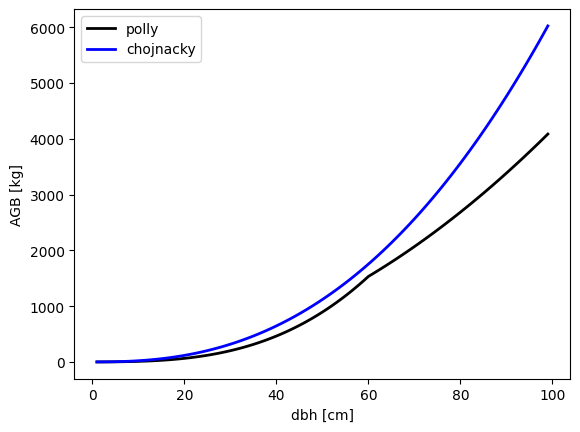

In [98]:
agwb_polly = dh2bagw_salda(p1 = pollys_params[0]["fates_allom_agb1"],
              p2 = pollys_params[0]["fates_allom_agb2"],
              p3 = pollys_params[0]["fates_allom_agb3"],
              p4 = pollys_params[0]["fates_allom_agb4"],
              allom_agb_frac=0.6,
              ds=diams,
              heights=h_polly,
              wood_density=0.446)

agb_polly = np.array(agwb_polly) + np.array(blmax_polly)
plt.plot(diams, agb_polly, label = "polly",color = "black", lw = 2)

agb_chojnacky = Chojnacky_d2_AGB(ds = diams,b0 = -2.6177,b1 = 2.4638)

plt.xlabel('dbh [cm]')
plt.ylabel('AGB [kg]')
plt.plot(diams, agb_chojnacky, label = "chojnacky",color = "blue", lw = 2)
plt.legend()
plt.show()

## Write out file

In [103]:
allometry_range_df = pd.DataFrame.from_dict(allometry_dict)

if write_to_csv == True:

    now = datetime.now()
    dt_string = now.strftime("%m-%d-%Y-%H-%M-%S")
    file_path = "pine_param_ranges_data_derived_" + dt_string + ".csv"
    allometry_range_df.to_csv(file_path, index=False)

In [104]:
allometry_range_df

,fates_name,min_value,max_value,mean
0,fates_allom_d2h1,8.089915e-01,8.537199e-01,0.831356
1,fates_allom_d2h2,-2.815632e-02,4.455624e-02,0.008200
2,fates_allom_d2bl1,-6.337253e+05,6.337255e+05,0.096347
3,fates_allom_d2bl2,1.949042e+00,2.492974e+00,2.221008
4,fates_allom_d2bl3,-8.146180e+06,8.146187e+06,3.555916
5,fates_allom_d2ca_coefficient_min,2.887947e-02,8.287230e-02,0.055876
6,fates_allom_d2ca_coefficient_max,2.887947e-02,8.287230e-02,0.055876
7,fates_allom_blca_expnt_diff,-4.536625e-01,-7.622834e-01,-0.607973


### Check range of possible tree vai's

In [133]:
PIPO_slatop = 0.00935078582102433 # m2 per g of C
PIPO_slatop = 0.013 # m2 per g of C

In [140]:
leaf_biomass = d2blmax_salda(ds = diams,
                            p1 = fates_allom_d2bl1[2],
                            p2 = fates_allom_d2bl2[2],
                            p3 = fates_allom_d2bl3[2],
                            wood_density = 0.446,
                            dbh_maxh = 80)

leaf_biomass_g = np.array(leaf_biomass) * 1000
print("leaf biomass g",leaf_biomass_g[-10:])

leaf_area_m2 = leaf_biomass_g * PIPO_slatop
print("leaf_area",leaf_area_m2[-10:])

# Optimized fates params
ca,cd = d_to_crown_area_fates(ds=diams,
                              d2bl_p2=fates_allom_d2bl2[2],
                              d2bl_ediff=fates_allom_blca_expnt_diff[2],
                              d2ca_max=fates_allom_d2ca_coefficient_max[2],
                              d2ca_min=fates_allom_d2ca_coefficient_min[2],
                              spread=0.5, dbh_maxh=80)

print("crown area",ca[-10:])

tree_vai = (np.array(leaf_area_m2) / np.array(ca)) * 1.1
print("tree vai",tree_vai)

leaf biomass g [91977.29218063 91977.29218063 91977.29218063 91977.29218063
 91977.29218063 91977.29218063 91977.29218063 91977.29218063
 91977.29218063 91977.29218063]
leaf_area [1195.70479835 1195.70479835 1195.70479835 1195.70479835 1195.70479835
 1195.70479835 1195.70479835 1195.70479835 1195.70479835 1195.70479835]
crown area [65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332, 65.61075410243332]
tree vai [ 1.39641467  2.12829829  2.72327324  3.24377401  3.71508929  4.15058499
  4.55838652  4.94388867  5.31089888  5.66222794  6.00002392  6.32597402
  6.64143344  6.94751097  7.24512813  7.53506106  7.81797106  8.09442728
  8.36492394  8.62989361  8.88971755  9.14473394  9.3952445   9.64151979
  9.88380362 10.12231661 10.35725924 10.58881435 10.81714924 11.0424175
 11.26476056 11.48430899 11.70118366 11.91549671 12.12735247 12.33684813
 12.54407449 12.7491165  12.95